# Importing libraries and data¶

## Libraries and settings

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
# import lightgbm as lgb

# from utils import *

In [2]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 15
random.seed(0)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

# Importing data and overview

In [7]:
calendar_df = pd.read_csv('/Users/ashutoshfolane/Documents/VIBHUTI/Git_Repos/Datasets/calendar.csv', parse_dates=['date'])
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [9]:
# Extract money value
def extract_money(text):
    if isinstance(text, str):
        text = text.replace('$','')
        text = text.replace(',','')
        money = float(text.replace('$',''))
    else:
        money=text
    return money

In [10]:
# Calendar data
calendar_df['price'] = calendar_df['price'].apply(lambda x: extract_money(x))
calendar_df['available'] = calendar_df['available'].map({'t':1, 'f':0})
calendar_df['revenue'] = calendar_df['price']*calendar_df['available']
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


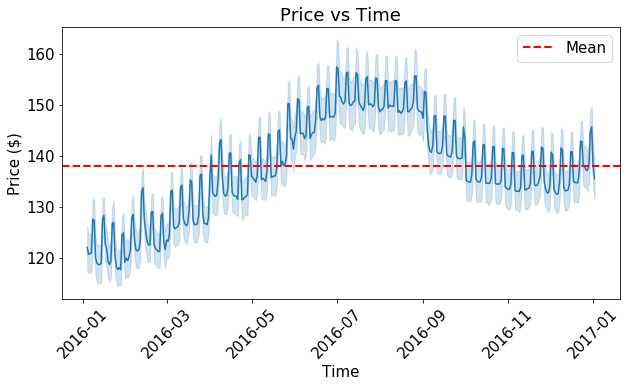

In [13]:
ax = sns.lineplot(x = "date", y = "price", 
                  markers = True, dashes = False, data = calendar_df)
plt.axhline(calendar_df['price'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 45)
plt.title('Price vs Time')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend(loc='best')
plt.show()

<B><u>Observations:</u></B>

- All hosts are existing hosts: i.e. they have all joined before 2016
- The listing information is almost exactly one year (Jan-2016 to Jan-2019)
- The price is on average 140 USD. All the small peaks indicates the weekend period when both demands and price increase.
- The price becomes highest during summer, likely because this is holliday season.
- The price listed in listings dataframe is just the lowest price. Prices can be adjusted by the hosts, based on seasons

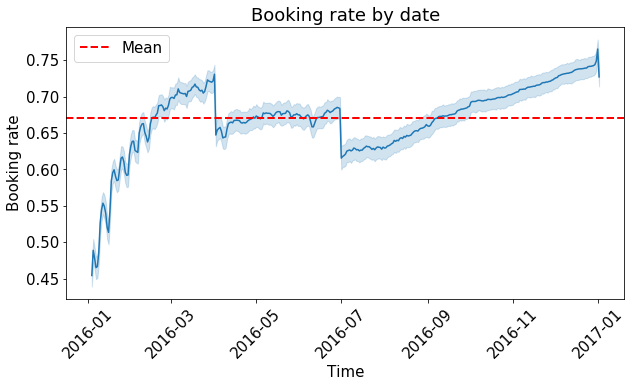

In [15]:
ax = sns.lineplot(x = "date", y = "available", 
                  markers = True, dashes = False, data = calendar_df)
plt.axhline(calendar_df['available'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 45)
plt.title('Booking rate by date')
plt.xlabel('Time')
plt.ylabel('Booking rate')
plt.legend(loc='best')
plt.show()

<B><u>Observations:</u></B>

- Booking rate drop by April (Easter) and July (US Independence Day) where people mostly return and celebrate with family rather than travel
- Booking drop significantly at the beginning and at the end of the year, because of End Year Holliday.

In [16]:
# Calculate financial overview of the booking
calendar_df = calendar_df.fillna(0)
calendar_df.head()


,listing_id,date,available,price,revenue
0,241032,2016-01-04,1,85.0,85.0
1,241032,2016-01-05,1,85.0,85.0
2,241032,2016-01-06,0,0.0,0.0
3,241032,2016-01-07,0,0.0,0.0
4,241032,2016-01-08,0,0.0,0.0


In [19]:
overview = calendar_df.groupby('listing_id')['available','price'].mean()
overview.columns = ['booking_rate(%)', 'daily_revenue']
overview['booking_rate(%)'] = overview['booking_rate(%)']*100
overview

,booking_rate(%),daily_revenue
listing_id,,
3335,84.657534,101.589041
4291,100.000000,82.000000
5682,84.657534,45.668493
6606,100.000000,92.849315
7369,14.520548,12.342466
...,...,...
10332096,100.000000,40.000000
10334184,98.904110,118.684932
10339144,0.000000,0.000000


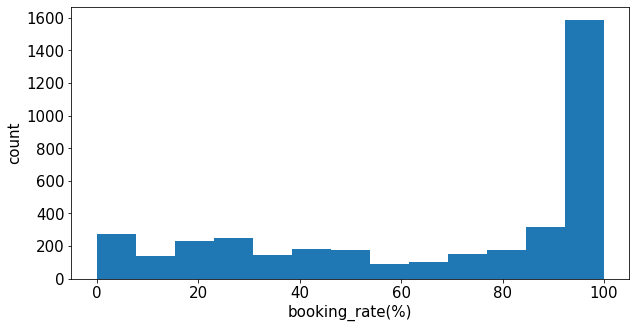

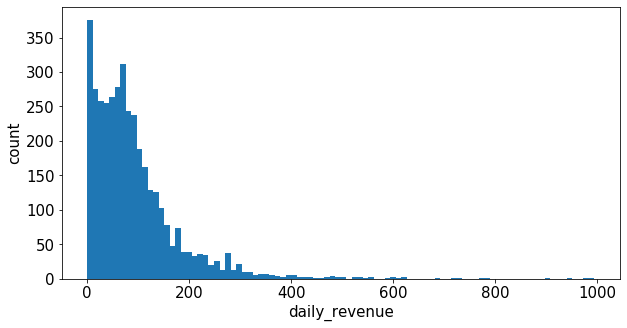

In [20]:
for col in overview.columns:
    plt.figure()
    plt.hist(overview[col], bins='auto')
    plt.xlabel(col)
    plt.ylabel('count')

In [21]:
print('Average daily revenue: %f USD' %np.mean(overview['daily_revenue']))

Average daily revenue: 92.507204 USD


<B><u>Observations:</B></u>

- Booking rate is in general high. The majority of hosts are fully-booked throughout the year.
- The daily revenue is on average 100 USD/day. Some exeptional case got 1000 USD/day. This can be outliers that cloud our predictions


In [23]:
# Actual average price
calendar_booked = calendar_df[calendar_df['price']!=0]
calendar_booked

,listing_id,date,available,price,revenue
0,241032,2016-01-04,1,85.0,85.0
1,241032,2016-01-05,1,85.0,85.0
9,241032,2016-01-13,1,85.0,85.0
10,241032,2016-01-14,1,85.0,85.0
14,241032,2016-01-18,1,85.0,85.0
...,...,...,...,...,...
1393207,10208623,2016-01-06,1,87.0,87.0
1393208,10208623,2016-01-07,1,87.0,87.0
1393211,10208623,2016-01-10,1,87.0,87.0
1393212,10208623,2016-01-11,1,87.0,87.0


In [24]:
calendar_booked = calendar_booked.groupby('listing_id').agg({'price':['mean','std']}).reset_index()
calendar_booked

listing_id       price           
                       mean        std
0          3335  120.000000   0.000000
1          4291   82.000000   0.000000
2          5682   53.944984   5.025282
3          6606   92.849315   4.520014
4          7369   85.000000   0.000000
...         ...         ...        ...
3718   10331249   45.000000   0.000000
3719   10332096   40.000000   0.000000
3720   10334184  120.000000   0.000000
3721   10339145  237.904110  33.420467
3722   10340165   43.000000   0.000000

[3723 rows x 3 columns]

In [25]:
calendar_booked.columns=['listing_id','price_avg','price_std']
calendar_booked

,listing_id,price_avg,price_std
0,3335,120.000000,0.000000
1,4291,82.000000,0.000000
2,5682,53.944984,5.025282
3,6606,92.849315,4.520014
4,7369,85.000000,0.000000
...,...,...,...
3718,10331249,45.000000,0.000000
3719,10332096,40.000000,0.000000
3720,10334184,120.000000,0.000000
3721,10339145,237.904110,33.420467


In [26]:
# Overview
listings_df = pd.read_csv('/Users/ashutoshfolane/Documents/VIBHUTI/Git_Repos/Datasets/listings.csv')
listings_df

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [27]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [28]:
house_properties = ['bathrooms', 'bedrooms', 'beds', 'room_type', 'accommodates', 'bed_type','property_type','neighbourhood_group_cleansed']
host_policies = ['guests_included','minimum_nights', 'maximum_nights','cancellation_policy','require_guest_phone_verification','require_guest_profile_picture','host_has_profile_pic', 'host_identity_verified']
pricing_strategies = ['price','cleaning_fee','extra_people']

In [29]:
useful_cols = ['id'] + house_properties + host_policies + pricing_strategies 
listings_df = listings_df[useful_cols]
listings_df.head()

,id,bathrooms,bedrooms,beds,room_type,accommodates,bed_type,property_type,neighbourhood_group_cleansed,guests_included,minimum_nights,maximum_nights,cancellation_policy,require_guest_phone_verification,require_guest_profile_picture,host_has_profile_pic,host_identity_verified,price,cleaning_fee,extra_people
0,241032,1.0,1.0,1.0,Entire home/apt,4,Real Bed,Apartment,Queen Anne,2,1,365,moderate,f,f,t,t,$85.00,NaN,$5.00
1,953595,1.0,1.0,1.0,Entire home/apt,4,Real Bed,Apartment,Queen Anne,1,2,90,strict,t,t,t,t,$150.00,$40.00,$0.00
2,3308979,4.5,5.0,7.0,Entire home/apt,11,Real Bed,House,Queen Anne,10,4,30,strict,f,f,t,t,$975.00,$300.00,$25.00
3,7421966,1.0,0.0,2.0,Entire home/apt,3,Real Bed,Apartment,Queen Anne,1,1,1125,flexible,f,f,t,t,$100.00,NaN,$0.00
4,278830,2.0,3.0,3.0,Entire home/apt,6,Real Bed,House,Queen Anne,6,1,1125,strict,f,f,t,t,$450.00,$125.00,$15.00


In [31]:
# Merge with calendar data
listings_df = pd.merge(listings_df, overview, how='left', left_on='id', right_on='listing_id')
listings_df = pd.merge(listings_df, calendar_booked, how='left', left_on='id', right_on='listing_id')
listings_df = listings_df.drop(['listing_id'], axis=1)
listings_df['price_per_person'] = listings_df['price']/listings_df['accommodates']
listings_df.head()

,id,bathrooms,bedrooms,beds,room_type,accommodates,bed_type,property_type,neighbourhood_group_cleansed,guests_included,minimum_nights,maximum_nights,cancellation_policy,require_guest_phone_verification,require_guest_profile_picture,host_has_profile_pic,host_identity_verified,price,cleaning_fee,extra_people,booking_rate(%)_x,daily_revenue_x,booking_rate(%)_y,daily_revenue_y,price_avg,price_std
0,241032,1.0,1.0,1.0,Entire home/apt,4,Real Bed,Apartment,Queen Anne,2,1,365,moderate,f,f,t,t,$85.00,NaN,$5.00,94.794521,80.575342,94.794521,80.575342,85.000000,0.000000
1,953595,1.0,1.0,1.0,Entire home/apt,4,Real Bed,Apartment,Queen Anne,1,2,90,strict,t,t,t,t,$150.00,$40.00,$0.00,79.726027,136.276712,79.726027,136.276712,170.931271,37.225252
2,3308979,4.5,5.0,7.0,Entire home/apt,11,Real Bed,House,Queen Anne,10,4,30,strict,f,f,t,t,$975.00,$300.00,$25.00,60.273973,784.657534,60.273973,784.657534,1301.818182,356.322687
3,7421966,1.0,0.0,2.0,Entire home/apt,3,Real Bed,Apartment,Queen Anne,1,1,1125,flexible,f,f,t,t,$100.00,NaN,$0.00,39.178082,39.178082,39.178082,39.178082,100.000000,0.000000
4,278830,2.0,3.0,3.0,Entire home/apt,6,Real Bed,House,Queen Anne,6,1,1125,strict,f,f,t,t,$450.00,$125.00,$15.00,100.000000,462.739726,100.000000,462.739726,462.739726,23.703194


In [32]:
pricing_strategies = pricing_strategies + ['price_avg','price_std', 'price_per_person']
pricing_strategies

['price',
 'cleaning_fee',
 'extra_people',
 'price_avg',
 'price_std',
 'price_per_person']

In [ ]:
#function to check if any values are null.
def print_null(df):
    for col in df:
        if df[col].isnull().any():
            print('%s has %.0f null values: %.3f%%'%(col, df[col].isnull().sum(), df[col].isnull().sum()/df[col].count()*100))
            